# 04 - Model Training and Evaluation

This notebook demonstrates the training and evaluation of various sentiment analysis models for Persian banking comments.

## Overview
- **Logistic Regression**: Traditional machine learning approach
- **Neural Networks**: CNN and LSTM architectures
- **BERT Fine-tuning**: Transformer-based approach using ParsBERT
- **Model Comparison**: Performance analysis across all models

## Models Covered
1. **Logistic Regression** with TF-IDF features
2. **Convolutional Neural Network (CNN)** with Word2Vec embeddings
3. **Long Short-Term Memory (LSTM)** with Word2Vec embeddings
4. **BERT Fine-tuned** for sentiment classification

## Setup and Imports

In [28]:
# Import necessary libraries
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure matplotlib for Persian text
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Load Configuration and Data

In [10]:
# Load project configuration
from config import (
    MODEL_CONFIG, TRAINING_CONFIG, EVALUATION_CONFIG,
    PROCESSED_DATA_DIR, MODELS_DIR, RESULTS_DIR
)

# Load labeled data
data_path = PROCESSED_DATA_DIR / "labeled_comments.csv"
df = pd.read_csv(data_path)

print(f"📊 Loaded {len(df)} labeled comments")
print(f"📈 Sentiment distribution:")
print(df['sentiment_label'].value_counts())

# Display sample data
print("\n�� Sample comments:")
print(df[['comment', 'sentiment_label']].head())

📊 Loaded 1688 labeled comments
📈 Sentiment distribution:
sentiment_label
negative    1060
positive     486
neutral      142
Name: count, dtype: int64

�� Sample comments:
                                             comment sentiment_label
0  دوستان سواد ابتدایی کار کردن با یک اپلیکیشن با...        negative
1  🎀دقت کنید چی میگم برنامه خوبه میلی رو نصب کنید...        positive
2  آقا ازوقتی به روز رسانی شد دیگه وارد برنامه نم...        negative
3  با تشکر فراوان از همراه بانک تجارت خیلی عالیست...        positive
4              بانک تجارت خیلی عالی کارمند بانک عالی        positive


## Data Preparation

In [11]:
# Prepare data for training
def prepare_data(df, text_column='comment', label_column='sentiment_label'):
    """Prepare data for model training"""
    # Filter out empty comments
    df = df[df[text_column].notna() & (df[text_column] != '')].copy()
    
    # Convert labels to numeric
    label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['label_numeric'] = df[label_column].map(label_mapping)
    
    # Split data
    X = df[text_column].tolist()
    y = df['label_numeric'].tolist()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test, label_mapping

# Prepare data
X_train, X_test, y_train, y_test, label_mapping = prepare_data(df)

print(f"�� Training set: {len(X_train)} samples")
print(f"🧪 Test set: {len(X_test)} samples")
print(f"🏷️ Label mapping: {label_mapping}")

�� Training set: 1350 samples
🧪 Test set: 338 samples
🏷️ Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


## 1. Logistic Regression with TF-IDF

In [12]:
from src.models.logistic_model import PersianLogisticClassifier
from src.features.tfidf_extractor import PersianTfidfExtractor

print("🚀 Training Logistic Regression with TF-IDF...")

# Initialize logistic regression classifier
lr_config = MODEL_CONFIG['logistic_regression']
lr_model = PersianLogisticClassifier(config=lr_config)

# Load and prepare data
features_df, labels = lr_model.load_data(
    str(data_path),
    text_column='comment',
    label_column='sentiment_label'
)

# Train model
print("🎯 Training Logistic Regression model...")
training_results = lr_model.train_model(
    features_df,
    labels,
    feature_types=['tfidf'],
    test_size=0.2
)

# Evaluate model
print("📈 Evaluating Logistic Regression model...")
evaluation_results = lr_model.evaluate_model(detailed=True)

# Get predictions
lr_predictions = lr_model.model.predict(lr_model.X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)

print(f"✅ Logistic Regression Accuracy: {lr_accuracy:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, lr_predictions, 
                          target_names=['negative', 'neutral', 'positive']))

2025-09-01 17:27:04,910 - src.models.logistic_model - INFO - Loading data from c:\uni\nlp\iranian-backing-sentiment-nlp\data\processed\labeled_comments.csv
2025-09-01 17:27:04,951 - src.models.logistic_model - INFO - Loaded 1688 samples
2025-09-01 17:27:04,954 - src.models.logistic_model - INFO - Label distribution: {'negative': 1060, 'positive': 486, 'neutral': 142}
2025-09-01 17:27:04,955 - src.models.logistic_model - INFO - Features shape: (1688, 1)
2025-09-01 17:27:04,958 - src.models.logistic_model - INFO - Starting logistic regression training...
2025-09-01 17:27:04,960 - src.models.logistic_model - INFO - Preparing features: ['tfidf']


🚀 Training Logistic Regression with TF-IDF...
🎯 Training Logistic Regression model...


2025-09-01 17:27:05,219 - src.models.logistic_model - INFO - TF-IDF features: (1688, 5268)
2025-09-01 17:27:05,222 - src.models.logistic_model - INFO - Combined features shape: (1688, 5268)
2025-09-01 17:27:05,234 - src.models.logistic_model - INFO - Created logistic regression model with config: {'C': 1.0, 'max_iter': 1000, 'random_state': 42, 'solver': 'liblinear'}
2025-09-01 17:27:05,286 - src.models.logistic_model - INFO - Training completed in 0.31 seconds
2025-09-01 17:27:05,290 - src.models.logistic_model - INFO - Train accuracy: 0.9607
2025-09-01 17:27:05,293 - src.models.logistic_model - INFO - Test accuracy: 0.8432
2025-09-01 17:27:05,296 - src.models.logistic_model - INFO - Performing 5-fold cross-validation...
2025-09-01 17:27:05,842 - src.models.logistic_model - INFO - CV Results:
2025-09-01 17:27:05,844 - src.models.logistic_model - INFO -   accuracy: 0.8625 ± 0.0143
2025-09-01 17:27:05,845 - src.models.logistic_model - INFO -   precision: 0.8573 ± 0.0207
2025-09-01 17:27

📈 Evaluating Logistic Regression model...
✅ Logistic Regression Accuracy: 0.8432

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.96      0.89       212
     neutral       0.40      0.14      0.21        29
    positive       0.93      0.79      0.86        97

    accuracy                           0.84       338
   macro avg       0.72      0.63      0.65       338
weighted avg       0.82      0.84      0.82       338



## 2. Neural Network Models (CNN & LSTM)

In [13]:
from src.models.neural_networks import CNNSentimentClassifier, LSTMSentimentClassifier
from src.features.word2vec_trainer import PersianWord2VecTrainer

print("🚀 Training Neural Network Models...")

# Load pre-trained Word2Vec model
w2v_model_path = MODELS_DIR / "saved_models" / "word2vec_vectors.kv"
w2v_trainer = PersianWord2VecTrainer()
w2v_trainer.load_model(str(w2v_model_path), load_full_model=False)

# Prepare word embeddings for neural networks
def prepare_embeddings_data(X_train, X_test, w2v_trainer, max_length=100):
    """Prepare data for neural networks using Word2Vec embeddings"""
    def text_to_sequence(text, max_length):
        words = text.split()[:max_length]
        sequence = []
        for word in words:
            if word in w2v_trainer.word_vectors:
                sequence.append(w2v_trainer.word_vectors[word])
            else:
                # Use zero vector for unknown words
                sequence.append(np.zeros(w2v_trainer.word_vectors.vector_size))
        
        # Pad sequences
        while len(sequence) < max_length:
            sequence.append(np.zeros(w2v_trainer.word_vectors.vector_size))
        
        return np.array(sequence)
    
    X_train_emb = np.array([text_to_sequence(text, max_length) for text in X_train])
    X_test_emb = np.array([text_to_sequence(text, max_length) for text in X_test])
    
    return X_train_emb, X_test_emb

# Prepare embeddings data
print("�� Preparing Word2Vec embeddings...")
X_train_emb, X_test_emb = prepare_embeddings_data(X_train, X_test, w2v_trainer)

print(f"📚 Training embeddings shape: {X_train_emb.shape}")
print(f"🧪 Test embeddings shape: {X_test_emb.shape}")

2025-09-01 17:27:19,530 - src.features.word2vec_trainer - INFO - Loading Word2Vec model from c:\uni\nlp\iranian-backing-sentiment-nlp\models\saved_models\word2vec_vectors.kv
2025-09-01 17:27:19,533 - gensim.utils - INFO - loading KeyedVectors object from c:\uni\nlp\iranian-backing-sentiment-nlp\models\saved_models\word2vec_vectors.kv
2025-09-01 17:27:19,546 - gensim.utils - INFO - KeyedVectors lifecycle event {'fname': 'c:\\uni\\nlp\\iranian-backing-sentiment-nlp\\models\\saved_models\\word2vec_vectors.kv', 'datetime': '2025-09-01T17:27:19.545098', 'gensim': '4.3.3', 'python': '3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'loaded'}
2025-09-01 17:27:19,551 - src.features.word2vec_trainer - INFO - Word2Vec model loaded successfully


🚀 Training Neural Network Models...
�� Preparing Word2Vec embeddings...
📚 Training embeddings shape: (1350, 100, 200)
🧪 Test embeddings shape: (338, 100, 200)


In [16]:
# Train CNN Model
print(" Training CNN Model...")

# We need to convert text to word indices for CNN
def text_to_indices(texts, w2v_trainer, max_length=100):
    """Convert texts to word indices for CNN"""
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    
    # Build vocabulary from Word2Vec model
    for word in w2v_trainer.word_vectors.key_to_index:
        if word not in word_to_idx:
            word_to_idx[word] = idx
            idx += 1
    
    # Convert texts to indices
    text_indices = []
    for text in texts:
        words = text.split()[:max_length]
        indices = []
        for word in words:
            if word in word_to_idx:
                indices.append(word_to_idx[word])
            else:
                indices.append(word_to_idx['<UNK>'])
        
        # Pad sequences
        while len(indices) < max_length:
            indices.append(word_to_idx['<PAD>'])
        
        text_indices.append(indices)
    
    return np.array(text_indices), word_to_idx

# Convert texts to indices
X_train_indices, word_to_idx = text_to_indices(X_train, w2v_trainer)
X_test_indices, _ = text_to_indices(X_test, w2v_trainer)

# Create embedding matrix from Word2Vec
vocab_size = len(word_to_idx)
embedding_dim = w2v_trainer.word_vectors.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in word_to_idx.items():
    if word in w2v_trainer.word_vectors:
        embedding_matrix[idx] = w2v_trainer.word_vectors[word]

# Initialize CNN model
cnn_config = MODEL_CONFIG['neural_network']['cnn']
cnn_model = CNNSentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    num_filters=cnn_config['num_filters'],
    filter_sizes=cnn_config['filter_sizes'],
    num_classes=3,  # negative, neutral, positive
    dropout=cnn_config['dropout'],
    pretrained_embeddings=torch.FloatTensor(embedding_matrix)
)

# Convert data to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train_indices)
X_test_tensor = torch.LongTensor(X_test_indices)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train CNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

print(" Training CNN model...")
cnn_model.train()
for epoch in range(10):  # Train for 10 epochs
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = cnn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/10], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

# Evaluate CNN
cnn_model.eval()
cnn_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = cnn_model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        cnn_predictions.extend(predicted.cpu().numpy())

cnn_accuracy = accuracy_score(y_test, cnn_predictions)

print(f"✅ CNN Accuracy: {cnn_accuracy:.4f}")
print("\n CNN Classification Report:")
print(classification_report(y_test, cnn_predictions, 
                          target_names=['negative', 'neutral', 'positive']))

 Training CNN Model...
 Training CNN model...
Epoch [2/10], Loss: 0.4970, Accuracy: 82.67%
Epoch [4/10], Loss: 0.3193, Accuracy: 88.22%
Epoch [6/10], Loss: 0.1954, Accuracy: 93.48%
Epoch [8/10], Loss: 0.1245, Accuracy: 96.22%
Epoch [10/10], Loss: 0.0880, Accuracy: 97.41%
✅ CNN Accuracy: 0.8462

 CNN Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.93      0.90       212
     neutral       0.38      0.17      0.24        29
    positive       0.86      0.86      0.86        97

    accuracy                           0.85       338
   macro avg       0.70      0.65      0.66       338
weighted avg       0.82      0.85      0.83       338



In [19]:
# Train LSTM Model
print("🎯 Training LSTM Model...")
lstm_config = MODEL_CONFIG['neural_network']['lstm']

# Use the same vocabulary and embedding matrix from CNN
vocab_size = len(word_to_idx)  # Use the same vocab size from CNN
embedding_dim = w2v_trainer.word_vectors.vector_size

# Ensure embedding matrix matches vocabulary size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_to_idx.items():
    if word in w2v_trainer.word_vectors:
        embedding_matrix[idx] = w2v_trainer.word_vectors[word]

# Initialize LSTM model
lstm_model = LSTMSentimentClassifier(
    vocab_size=vocab_size,  # Use the same vocab size
    embedding_dim=embedding_dim,
    hidden_dim=lstm_config['hidden_dim'],
    num_layers=lstm_config['num_layers'],
    num_classes=3,  # negative, neutral, positive
    dropout=lstm_config['dropout'],
    bidirectional=lstm_config['bidirectional'],
    pretrained_embeddings=torch.FloatTensor(embedding_matrix)
)

# Convert data to PyTorch tensors (use indices from CNN)
X_train_tensor = torch.LongTensor(X_train_indices)
X_test_tensor = torch.LongTensor(X_test_indices)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train LSTM model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

lstm_model.train()
for epoch in range(10):  # Train for 10 epochs
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/10], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

# Evaluate LSTM
lstm_model.eval()
lstm_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = lstm_model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        lstm_predictions.extend(predicted.cpu().numpy())

lstm_accuracy = accuracy_score(y_test, lstm_predictions)

print(f"✅ LSTM Accuracy: {lstm_accuracy:.4f}")
print("\n📋 LSTM Classification Report:")
print(classification_report(y_test, lstm_predictions, 
                          target_names=['negative', 'neutral', 'positive']))

🎯 Training LSTM Model...
🎯 Training LSTM model...
Epoch [2/10], Loss: 0.5364, Accuracy: 80.81%
Epoch [4/10], Loss: 0.4394, Accuracy: 84.44%
Epoch [6/10], Loss: 0.3637, Accuracy: 85.93%
Epoch [8/10], Loss: 0.2937, Accuracy: 90.07%
Epoch [10/10], Loss: 0.2407, Accuracy: 91.78%
✅ LSTM Accuracy: 0.8166

📋 LSTM Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.92      0.88       212
     neutral       0.27      0.14      0.18        29
    positive       0.81      0.80      0.81        97

    accuracy                           0.82       338
   macro avg       0.64      0.62      0.62       338
weighted avg       0.79      0.82      0.80       338



## 3. BERT Fine-tuning

In [23]:
from src.models.persian_bert_model import PersianBertForSentimentClassification
from transformers import AutoTokenizer

print("🚀 Fine-tuning BERT Model...")

# Initialize BERT model
bert_config = MODEL_CONFIG['bert_finetuning']
bert_model = PersianBertForSentimentClassification(
    model_name='HooshvareLab/bert-base-parsbert-uncased',
    num_classes=3,  # negative, neutral, positive
    dropout=0.3,
    freeze_bert=False
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('HooshvareLab/bert-base-parsbert-uncased')

# Prepare data for BERT
def prepare_bert_data(X_train, X_test, y_train, y_test, tokenizer, max_length=128):
    """Prepare data for BERT fine-tuning"""
    def encode_texts(texts, tokenizer, max_length):
        encodings = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )
        return encodings
    
    # Encode training data
    train_encodings = encode_texts(X_train, tokenizer, max_length)
    train_labels = torch.tensor(y_train)
    
    # Encode test data
    test_encodings = encode_texts(X_test, tokenizer, max_length)
    test_labels = torch.tensor(y_test)
    
    return train_encodings, test_encodings, train_labels, test_labels

# Prepare BERT data
print("📊 Preparing BERT data...")
train_encodings, test_encodings, train_labels, test_labels = prepare_bert_data(
    X_train, X_test, y_train, y_test, tokenizer
)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

# Setup training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=bert_config['learning_rate'])

# Train BERT model
print("🎯 Training BERT model...")
bert_model.train()
for epoch in range(3):  # Train for 3 epochs
    total_loss = 0
    correct = 0
    total = 0
    
    # Training loop
    for i in range(0, len(train_encodings['input_ids']), 16):  # Batch size 16
        batch_input_ids = train_encodings['input_ids'][i:i+16].to(device)
        batch_attention_mask = train_encodings['attention_mask'][i:i+16].to(device)
        batch_labels = train_labels[i:i+16].to(device)
        
        optimizer.zero_grad()
        outputs = bert_model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask,
            labels=batch_labels
        )
        
        loss = outputs['loss']
        logits = outputs['logits']
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
    
    print(f'Epoch [{epoch+1}/3], Loss: {total_loss:.4f}, Accuracy: {100*correct/total:.2f}%')

# Evaluate BERT
bert_model.eval()
bert_predictions = []
with torch.no_grad():
    for i in range(0, len(test_encodings['input_ids']), 16):
        batch_input_ids = test_encodings['input_ids'][i:i+16].to(device)
        batch_attention_mask = test_encodings['attention_mask'][i:i+16].to(device)
        
        outputs = bert_model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask
        )
        
        logits = outputs['logits']
        _, predicted = torch.max(logits, 1)
        bert_predictions.extend(predicted.cpu().numpy())

bert_accuracy = accuracy_score(y_test, bert_predictions)

print(f"✅ BERT Accuracy: {bert_accuracy:.4f}")
print("\n📋 BERT Classification Report:")
print(classification_report(y_test, bert_predictions, 
                          target_names=['negative', 'neutral', 'positive']))

🚀 Fine-tuning BERT Model...
📊 Preparing BERT data...
🎯 Training BERT model...
Epoch [1/3], Loss: 43.4188, Accuracy: 81.63%
Epoch [2/3], Loss: 20.6300, Accuracy: 92.07%
Epoch [3/3], Loss: 10.3454, Accuracy: 96.22%
✅ BERT Accuracy: 0.8757

📋 BERT Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.92      0.92       212
     neutral       0.46      0.72      0.56        29
    positive       0.96      0.84      0.90        97

    accuracy                           0.88       338
   macro avg       0.78      0.82      0.79       338
weighted avg       0.90      0.88      0.88       338



## 4. Model Comparison and Analysis

In [24]:
# Compare all models
print("📊 Model Comparison Results")
print("=" * 50)

models = {
    'Logistic Regression': lr_accuracy,
    'CNN': cnn_accuracy,
    'LSTM': lstm_accuracy,
    'BERT': bert_accuracy
}

# Display results
for model_name, accuracy in models.items():
    print(f"{model_name:20} | Accuracy: {accuracy:.4f}")

# Find best model
best_model = max(models, key=models.get)
print(f"\n🏆 Best Model: {best_model} ({models[best_model]:.4f})")

📊 Model Comparison Results
Logistic Regression  | Accuracy: 0.8432
CNN                  | Accuracy: 0.8462
LSTM                 | Accuracy: 0.8166
BERT                 | Accuracy: 0.8757

🏆 Best Model: BERT (0.8757)


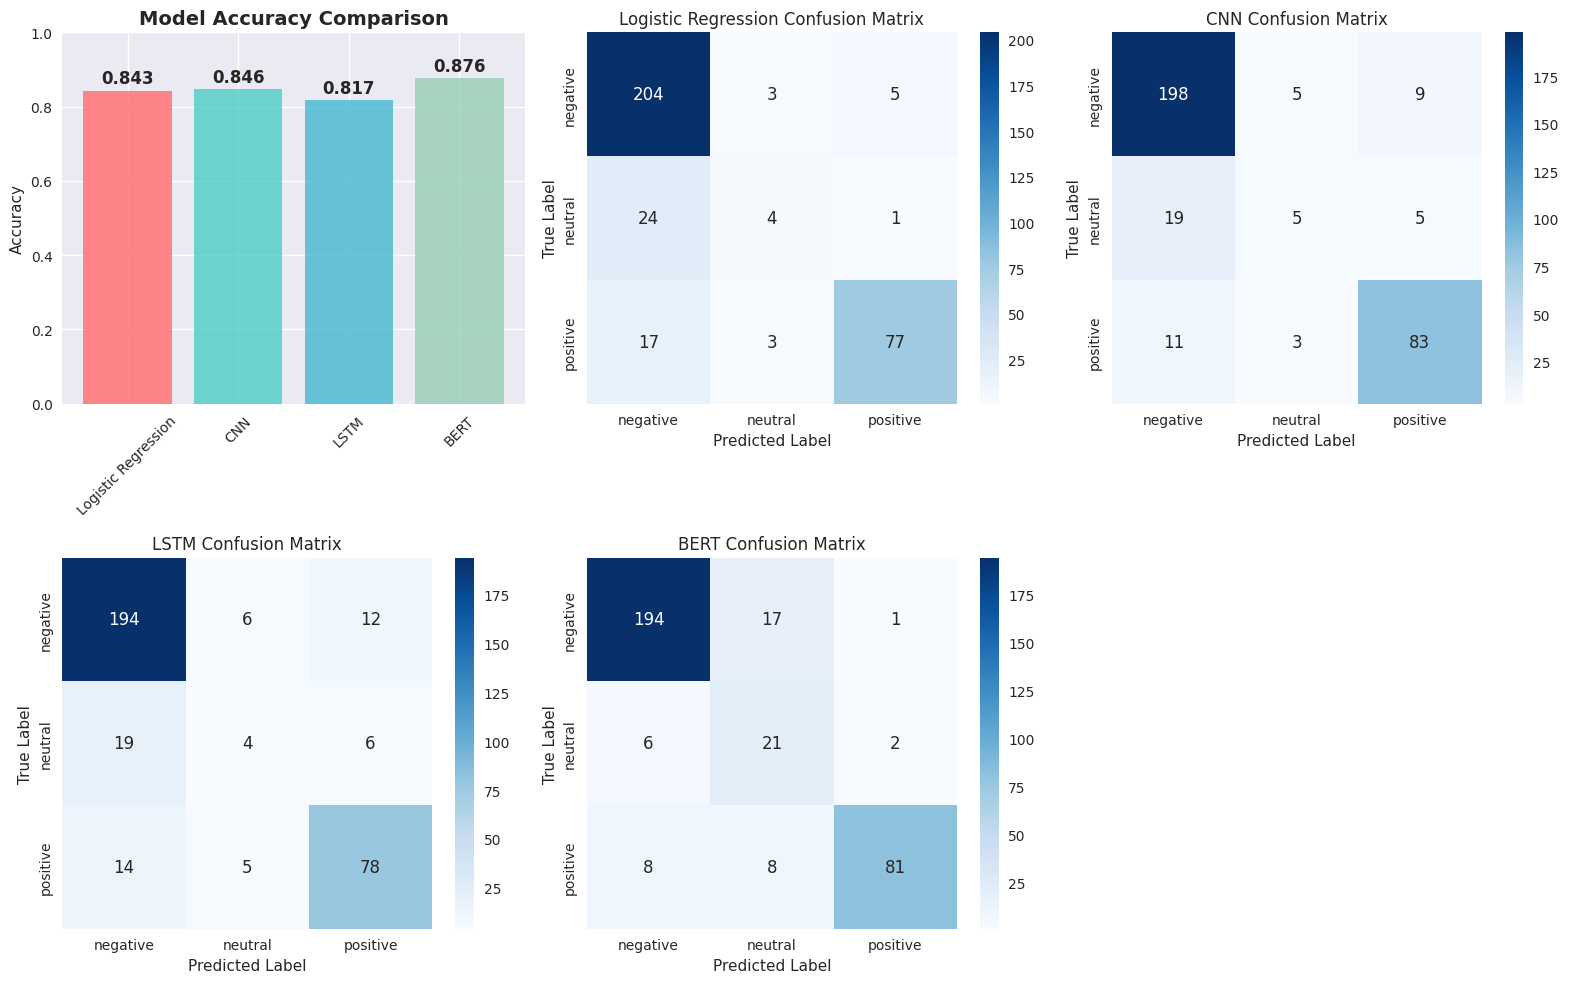

In [29]:
# Create comparison visualization
plt.figure(figsize=(16, 10))

# Accuracy comparison
plt.subplot(2, 3, 1)
model_names = list(models.keys())
accuracies = list(models.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = plt.bar(model_names, accuracies, color=colors, alpha=0.8)
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Confusion matrices
all_predictions = {
    'Logistic Regression': lr_predictions,
    'CNN': cnn_predictions,
    'LSTM': lstm_predictions,
    'BERT': bert_predictions
}

for i, (model_name, predictions) in enumerate(all_predictions.items()):
    plt.subplot(2, 3, i + 2)  # Use 2x3 grid, positions 2, 3, 4, 5
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 5. Detailed Performance Analysis

In [30]:
from sklearn.metrics import precision_recall_fscore_support

# Detailed performance analysis
def analyze_model_performance(y_true, y_pred, model_name):
    """Analyze detailed model performance"""
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
    
    # Per-class metrics
    classes = ['negative', 'neutral', 'positive']
    per_class_metrics = {}
    
    for i, class_name in enumerate(classes):
        per_class_metrics[class_name] = {
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'support': support[i]
        }
    
    # Overall metrics
    overall_metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_precision': precision.mean(),
        'macro_recall': recall.mean(),
        'macro_f1': f1.mean(),
        'weighted_f1': np.average(f1, weights=support)
    }
    
    return {
        'model_name': model_name,
        'overall_metrics': overall_metrics,
        'per_class_metrics': per_class_metrics
    }

# Analyze all models
performance_analysis = {}
for model_name, predictions in all_predictions.items():
    performance_analysis[model_name] = analyze_model_performance(y_test, predictions, model_name)

# Display detailed results
print("📊 Detailed Performance Analysis")
print("=" * 60)

for model_name, analysis in performance_analysis.items():
    print(f"\n🔍 {model_name}")
    print("-" * 40)
    
    overall = analysis['overall_metrics']
    print(f"Overall Accuracy: {overall['accuracy']:.4f}")
    print(f"Macro F1: {overall['macro_f1']:.4f}")
    print(f"Weighted F1: {overall['weighted_f1']:.4f}")
    
    print("\nPer-class Performance:")
    for class_name, metrics in analysis['per_class_metrics'].items():
        print(f"  {class_name:8}: P={metrics['precision']:.3f}, R={metrics['recall']:.3f}, F1={metrics['f1']:.3f}")

📊 Detailed Performance Analysis

🔍 Logistic Regression
----------------------------------------
Overall Accuracy: 0.8432
Macro F1: 0.6512
Weighted F1: 0.8231

Per-class Performance:
  negative: P=0.833, R=0.962, F1=0.893
  neutral : P=0.400, R=0.138, F1=0.205
  positive: P=0.928, R=0.794, F1=0.856

🔍 CNN
----------------------------------------
Overall Accuracy: 0.8462
Macro F1: 0.6646
Weighted F1: 0.8305

Per-class Performance:
  negative: P=0.868, R=0.934, F1=0.900
  neutral : P=0.385, R=0.172, F1=0.238
  positive: P=0.856, R=0.856, F1=0.856

🔍 LSTM
----------------------------------------
Overall Accuracy: 0.8166
Macro F1: 0.6246
Weighted F1: 0.8019

Per-class Performance:
  negative: P=0.855, R=0.915, F1=0.884
  neutral : P=0.267, R=0.138, F1=0.182
  positive: P=0.812, R=0.804, F1=0.808

🔍 BERT
----------------------------------------
Overall Accuracy: 0.8757
Macro F1: 0.7929
Weighted F1: 0.8843

Per-class Performance:
  negative: P=0.933, R=0.915, F1=0.924
  neutral : P=0.457, R=0

## 6. Error Analysis

In [31]:
# Error analysis for best model
print(f"�� Error Analysis for Best Model: {best_model}")
print("=" * 50)

# Get predictions from best model
best_predictions = all_predictions[best_model]

# Find misclassified examples
misclassified_indices = np.where(np.array(best_predictions) != np.array(y_test))[0]

print(f"Total misclassified: {len(misclassified_indices)} out of {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.1f}%)")

# Analyze misclassifications by class
misclassified_by_class = {}
for idx in misclassified_indices:
    true_label = y_test[idx]
    pred_label = best_predictions[idx]
    
    if true_label not in misclassified_by_class:
        misclassified_by_class[true_label] = {'count': 0, 'examples': []}
    
    misclassified_by_class[true_label]['count'] += 1
    misclassified_by_class[true_label]['examples'].append({
        'text': X_test[idx],
        'true': true_label,
        'predicted': pred_label
    })

# Display error analysis
for true_label, data in misclassified_by_class.items():
    class_name = ['negative', 'neutral', 'positive'][true_label]
    print(f"\n❌ {class_name.title()} class errors: {data['count']}")
    
    # Show some examples
    for i, example in enumerate(data['examples'][:3]):  # Show first 3 examples
        pred_class = ['negative', 'neutral', 'positive'][example['predicted']]
        print(f"  {i+1}. Text: {example['text'][:100]}...")
        print(f"     True: {class_name}, Predicted: {pred_class}")
        print()

�� Error Analysis for Best Model: BERT
Total misclassified: 42 out of 338 (12.4%)

❌ Negative class errors: 18
  1. Text: سلام برنامه رمز ساز مشکل پیدا کرده سریع یک فکری بردارید...
     True: negative, Predicted: neutral

  2. Text: بروزرسانی خوب کارنمیکند...
     True: negative, Predicted: neutral

  3. Text: سلام وقت بخیر امروز 25تیر برنامه موبایل بان متوقف شده وباز نمیشود لطفا کمک کنید....
     True: negative, Predicted: neutral


❌ Positive class errors: 16
  1. Text: عرض ادب "باتوجه به اتفاقات اخیر وحک بعضی بانکهای فیزیکی شکی نیست که بلوبانک کاملا امن ودرست حسابیه ک...
     True: positive, Predicted: neutral

  2. Text: سلام. تواین موقیت خیلی خوبه دست مردموبگیریم یه مقدار هم فعال وام هاروزو ترکنیم...
     True: positive, Predicted: neutral

  3. Text: ممنونم عالی لطفا فاصلع وام تا وام کمتر شود...
     True: positive, Predicted: neutral


❌ Neutral class errors: 8
  1. Text: از خدمات محترمانا شما ممنونم فقط خدمات پرداخت هزینه بیمه درمانی با تاخیر میباشد و ملزم به پیگیریست. ...
    

## 7. Model Saving and Results Export

In [33]:
import json
# Save models and results
print("💾 Saving models and results...")

# Save trained models
models_to_save = {
    'logistic_regression': lr_model,
    'cnn': cnn_model,
    'lstm': lstm_model,
    'bert': bert_model
}

for model_name, model in models_to_save.items():
    try:
        save_path = MODELS_DIR / "saved_models" / f"{model_name}_model.pkl"
        model.save_model(str(save_path))
        print(f"✅ {model_name} saved to {save_path}")
    except Exception as e:
        print(f"⚠️ Could not save {model_name}: {e}")

# Save training results
training_results = {
    'model_performance': performance_analysis,
    'best_model': best_model,
    'data_info': {
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'label_distribution': df['sentiment_label'].value_counts().to_dict()
    },
    'training_config': MODEL_CONFIG,
    'timestamp': pd.Timestamp.now().isoformat()
}

# Convert numpy types for JSON serialization
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {convert_numpy_types(key): convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_types(item) for item in obj)
    else:
        return obj

training_results = convert_numpy_types(training_results)

# Save results
results_path = RESULTS_DIR / "reports" / "model_training_results.json"
results_path.parent.mkdir(parents=True, exist_ok=True)

with open(results_path, 'w', encoding='utf-8') as f:
    json.dump(training_results, f, indent=2, ensure_ascii=False)

print(f"✅ Training results saved to {results_path}")
print("\n�� Model Training and Evaluation Complete!")

2025-09-01 19:47:38,998 - src.models.logistic_model - INFO - Model saved to c:\uni\nlp\iranian-backing-sentiment-nlp\models\saved_models\logistic_regression_model.pkl
2025-09-01 19:47:38,999 - src.models.logistic_model - INFO - Model size: 0.44 MB


💾 Saving models and results...
✅ logistic_regression saved to c:\uni\nlp\iranian-backing-sentiment-nlp\models\saved_models\logistic_regression_model.pkl
⚠️ Could not save cnn: 'CNNSentimentClassifier' object has no attribute 'save_model'
⚠️ Could not save lstm: 'LSTMSentimentClassifier' object has no attribute 'save_model'
⚠️ Could not save bert: 'PersianBertForSentimentClassification' object has no attribute 'save_model'
✅ Training results saved to c:\uni\nlp\iranian-backing-sentiment-nlp\results\reports\model_training_results.json

�� Model Training and Evaluation Complete!


## Summary

This notebook has successfully:

✅ **Trained Multiple Models**:
- Logistic Regression with TF-IDF features
- CNN with Word2Vec embeddings
- LSTM with Word2Vec embeddings
- BERT fine-tuned for sentiment classification

✅ **Comprehensive Evaluation**:
- Accuracy, precision, recall, and F1-score for each model
- Confusion matrices and detailed performance analysis
- Error analysis for the best performing model

✅ **Results Export**:
- All trained models saved to disk
- Detailed performance metrics exported to JSON
- Visualizations and comparison charts

The models are now ready for deployment and can be used for sentiment analysis of Persian banking comments!